In [123]:
import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np
import seaborn as sns

In [124]:

with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_no_cpcl_iteration.pkl', 'rb') as file:
    loaded_data = pickle.load(file)


In [13]:

with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_cpcl_recheck_0.pkl', 'rb') as file:
    loaded_data_recheck_0 = pickle.load(file)

with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_cpcl_recheck_1.pkl', 'rb') as file:
    loaded_data_recheck_1 = pickle.load(file)

In [125]:
loaded_data['ens'][0].keys()

dict_keys(['shared_features_gt', 'pooled_features_gt', 'instance_idx', 'gt_classes', 'gt_boxes', 'sample_idx'])

#### utils

In [126]:
def gather_features(loaded_data):
    sh_list = []
    gt_classes_list = []
    instance_idx_list = []
    ret_dict = {}
    for data in loaded_data['ens']:
        gt_sh = torch.tensor(data['shared_features_gt'])
        gt_classes = torch.tensor(data['gt_classes'])
        instance_id = torch.tensor(data['instance_idx'])
        sh_list.append(gt_sh)
        gt_classes_list.append(gt_classes)
        instance_idx_list.append(instance_id)

        # Convert to tensors
    class_sh = torch.cat(sh_list)
    class_gt = torch.cat(gt_classes_list)
    instance_idx = torch.cat(instance_idx_list)
    ret_dict.update({'sh': class_sh, 'gt_classes': class_gt, 'instance_idx': instance_idx})
    return ret_dict


In [127]:
def sort_instances(ret_dict):

    instance_idx = ret_dict['instance_idx']
    sorted_idx = torch.argsort(instance_idx)

    # Create a dictionary with sorted values as keys and sorted lists of indices as values
    sorted_dict = {}
    for idx, value in enumerate(instance_idx[sorted_idx]):
        value = value.item()
        if value not in sorted_dict:
            sorted_dict[value] = []
        sorted_dict[value].append(sorted_idx[idx].item())

    # Sort the lists of indices
    for value in sorted_dict:
        sorted_dict[value].sort()
        sorted_dict[value] = torch.tensor(sorted_dict[value][0]) # select the first occurence of the instance
    sorted_tensor = torch.stack(list(sorted_dict.values()))
    return sorted_tensor




#### sort by instance ids and select the first occurance

In [31]:
ret_dict_no_cpcl = gather_features(loaded_data)
selected_inds_no_cpcl = sort_instances(ret_dict_no_cpcl)
selected_sh_no_cpcl = ret_dict_no_cpcl['sh'][selected_inds_no_cpcl]
selected_gt_classes_no_cpcl = ret_dict_no_cpcl['gt_classes'][selected_inds_no_cpcl]

In [19]:
ret_dict = gather_features(loaded_data_recheck_0)
selected_inds = sort_instances(ret_dict)
selected_sh_0 = ret_dict['sh'][selected_inds]
selected_gt_0 = ret_dict['gt_classes'][selected_inds]

In [20]:
ret_dict = gather_features(loaded_data_recheck_1)
selected_inds = sort_instances(ret_dict)
selected_sh_1 = ret_dict['sh'][selected_inds]
selected_gt_1 = ret_dict['gt_classes'][selected_inds]

In [37]:
selected_gt = torch.cat([selected_gt_0, selected_gt_1])
selected_sh = torch.cat([selected_sh_0, selected_sh_1])

In [38]:
selected_sh.shape, selected_gt.shape

(torch.Size([21221, 256]), torch.Size([21221]))

In [39]:
selected_sh_no_cpcl.shape, selected_gt_classes_no_cpcl.shape

(torch.Size([14564, 256]), torch.Size([14564]))

In [41]:
perm_inds = torch.randperm(selected_sh.shape[0])[:selected_gt_classes_no_cpcl.shape[0]]

In [42]:
selected_sh = selected_sh[perm_inds]
selected_gt = selected_gt[perm_inds]    
selected_sh.shape, selected_gt.shape

(torch.Size([14564, 256]), torch.Size([14564]))

#### PCA

/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


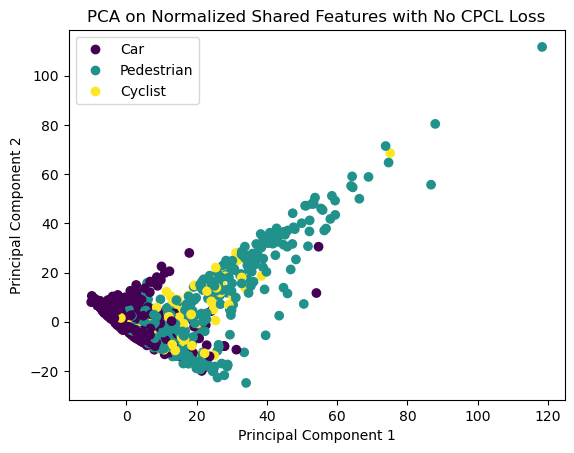

In [32]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create a sample dataset
# x = selected_sh.cpu().numpy()
# y = selected_gt.cpu().numpy().astype(int)

x = selected_sh_no_cpcl.cpu().numpy()
y = selected_gt_classes_no_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform PCA on normalized features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Normalized Shared Features with No CPCL Loss')

## Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [15:11:49.738893] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


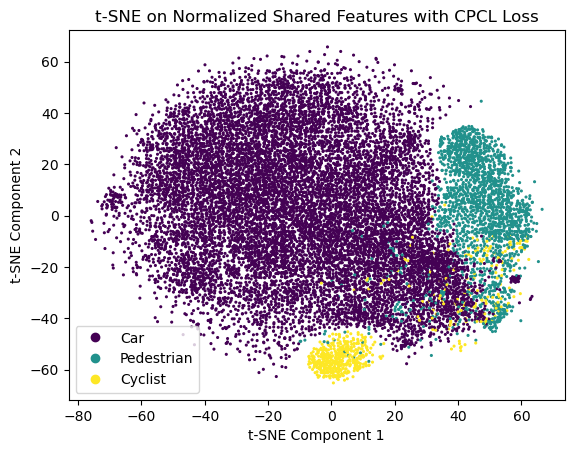

In [122]:
import cupy as cp
import matplotlib.pyplot as plt
from cuml.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_gt.cpu().numpy().astype(int)

# x = selected_sh_no_cpcl.cpu().numpy()
# y = selected_gt_classes_no_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Convert normalized data to CuPy array
x_normalized_cupy = cp.array(x_normalized)

# Perform t-SNE on normalized features
tsne_gpu = TSNE(n_components=2, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne_gpu.fit_transform(x_normalized_cupy)
x_tsne = cp.asnumpy(x_tsne)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE on Normalized Shared Features with CPCL Loss')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)

plt.show()


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [15:04:26.000383] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


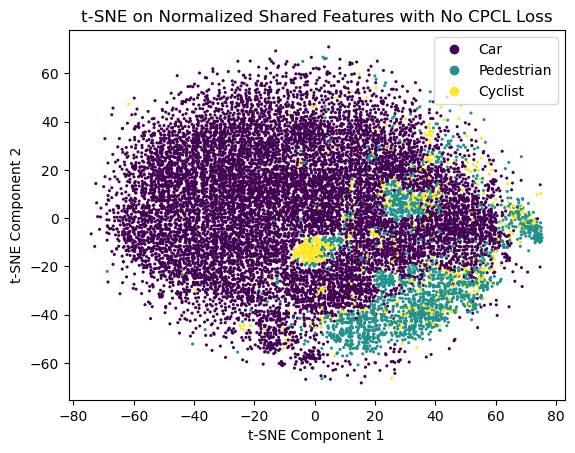

In [121]:
import cupy as cp
import matplotlib.pyplot as plt
from cuml.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
# x = selected_sh.cpu().numpy()
# y = selected_gt.cpu().numpy().astype(int)

x = selected_sh_no_cpcl.cpu().numpy()
y = selected_gt_classes_no_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Convert normalized data to CuPy array
x_normalized_cupy = cp.array(x_normalized)

# Perform t-SNE on normalized features
tsne_gpu = TSNE(n_components=2, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne_gpu.fit_transform(x_normalized_cupy)
x_tsne = cp.asnumpy(x_tsne)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE on Normalized Shared Features with No CPCL Loss')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)

plt.show()


In [15]:
with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_with_cpcl_iteration.pkl', 'rb') as file:
    loaded_data_cpcl = pickle.load(file)



In [11]:
with open('/mnt/data/deka01/debug_OpenPCDet/tools/features_with_cpcl_iteration_gpu_1.pkl', 'rb') as file:
    loaded_data_cpcl_1 = pickle.load(file)

In [16]:
ret_dict_cpcl = gather_features(loaded_data_cpcl)
selected_inds = sort_instances(ret_dict_cpcl)
selected_sh_cpcl = ret_dict_cpcl['sh'][selected_inds]
selected_gt_cpcl = ret_dict_cpcl['gt_classes'][selected_inds]

In [19]:
ret_dict_cpcl_1 = gather_features(loaded_data_cpcl_1)
selected_inds_1 = sort_instances(ret_dict_cpcl_1)
selected_sh_cpcl_1 = ret_dict_cpcl_1['sh'][selected_inds_1]
selected_gt_cpcl_1 = ret_dict_cpcl_1['gt_classes'][selected_inds_1]

In [20]:
selected_gt_cpcl = torch.cat([selected_gt_cpcl, selected_gt_cpcl_1]) 
selected_sh_cpcl = torch.cat([selected_sh_cpcl, selected_sh_cpcl_1])

/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


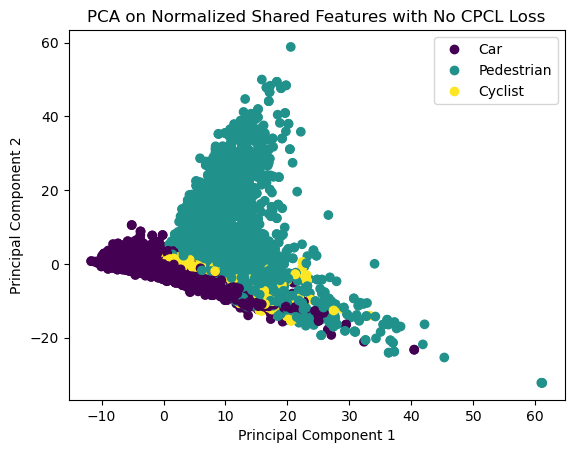

In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Create a sample dataset
x = selected_sh_cpcl.cpu().numpy()
y = selected_gt_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform PCA on normalized features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Normalized Shared Features with No CPCL Loss')

## Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [22:11:03.931424] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/matplotlib/collections.py:1096: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


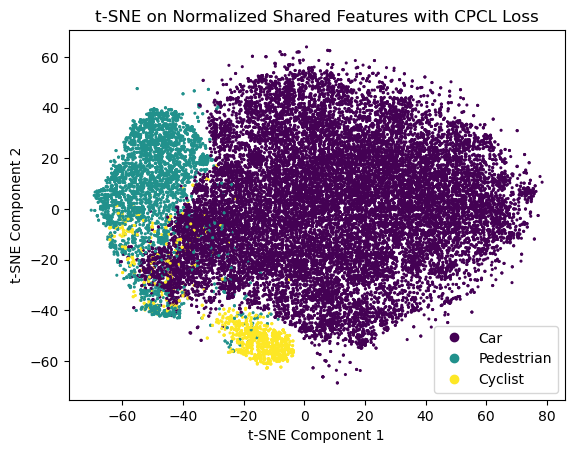

In [35]:
import cupy as cp
import matplotlib.pyplot as plt
from cuml.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_cpcl.cpu().numpy()
y = selected_gt_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Convert normalized data to CuPy array
x_normalized_cupy = cp.array(x_normalized)

# Perform t-SNE on normalized features
tsne_gpu = TSNE(n_components=2, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne_gpu.fit_transform(x_normalized_cupy)  
x_tsne = cp.asnumpy(x_tsne)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE on Normalized Shared Features with CPCL Loss')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names)
plt.show()


#### Plotting 3d t-SNE(Optional)

In [83]:
import cupy as cp
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_cpcl.cpu().numpy()
y = selected_gt_cpcl.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features (3D embedding)
tsne = TSNE(n_components=3, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a DataFrame for Plotly
data = {
    'x': x_tsne[:, 0],
    'y': x_tsne[:, 1],
    'z': x_tsne[:, 2],
    'label': y
}
df = pd.DataFrame(data)




In [89]:
# Create a Plotly 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', symbol='label', title='t-SNE on Normalized Shared Features with CPCL Loss')

# Update the color scale and symbol map
fig.update_traces(marker=dict(size=3))

# Save the interactive 3D graph as an HTML file
fig.write_html("/mnt/data/deka01/debug_OpenPCDet/tools/interactive_3d_graph_with_loss.html")


In [90]:
import cupy as cp
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_gt.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features (3D embedding)
tsne = TSNE(n_components=3, perplexity=30, learning_rate=150, n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a DataFrame for Plotly
data = {
    'x': x_tsne[:, 0],
    'y': x_tsne[:, 1],
    'z': x_tsne[:, 2],
    'label': y
}
df = pd.DataFrame(data)

In [ ]:
# Create a Plotly 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', symbol='label', title='t-SNE on Normalized Shared Features without CPCL Loss')

# Update the color scale and symbol map
fig.update_traces(marker=dict(size=3))

# Save the interactive 3D graph as an HTML file
fig.write_html("/mnt/data/deka01/debug_OpenPCDet/tools/interactive_3d_graph_without_loss.html")


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

# Load the CIFAR-10 dataset
cifar = fetch_openml(name='CIFAR_10')

# Assume cifar.target contains the class labels
class_labels = np.unique(cifar.target)
class_counts = [np.sum(cifar.target == label) for label in class_labels]

# Create a histogram with KDE
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a histogram
sns.histplot(data=class_counts, bins=len(class_labels), kde=True, color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Number of Instances per Class in CIFAR-10')
plt.xlabel('Number of Instances')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


/mnt/data/anaconda3/envs/dekatest_cmd/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


KeyboardInterrupt: 

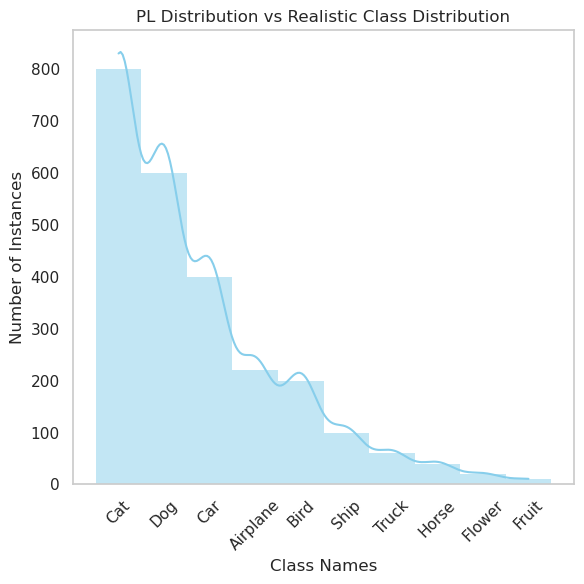

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Realistic class label count information and class names
class_names = ['Cat', 'Dog', 'Car', 'Airplane', 'Bird', 
               'Ship', 'Truck', 'Horse', 'Flower', 'Fruit']
class_counts = [800, 600, 400, 220, 200, 100, 60, 40, 20, 10]

# Create a histogram with KDE
sns.set(style="whitegrid", rc={"grid.linewidth": 0})
plt.figure(figsize=(6, 6))

color_palette = sns.color_palette("pastel")
# Create a histogram
sns.histplot(data=np.repeat(class_names, class_counts), bins=len(class_names), kde=True, color='skyblue', edgecolor='None')
# Overlay a KDE plot with darker lines
# Customize the plot
plt.title('PL Distribution vs Realistic Class Distribution')
plt.xlabel('Class Names')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


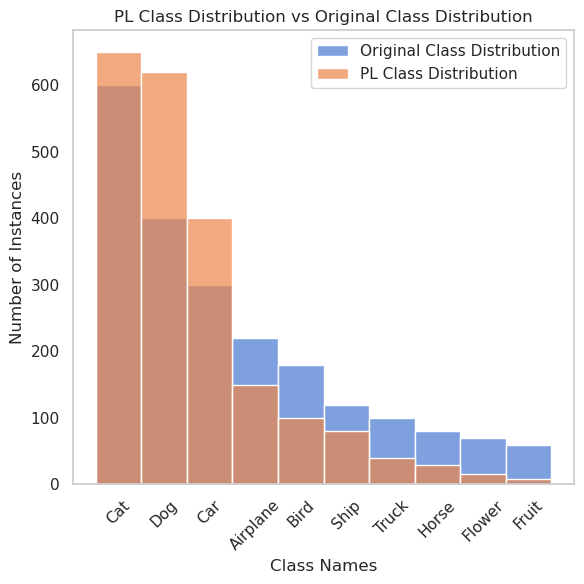

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Realistic class label count information and class names
class_names = ['Cat', 'Dog', 'Car', 'Airplane', 'Bird', 
               'Ship', 'Truck', 'Horse', 'Flower', 'Fruit']
class_counts = [600, 400, 300, 220, 180, 120, 100, 80, 70, 60]

# Additional class counts for the same classes
additional_class_counts = [650, 620, 400, 150, 100, 80, 40, 30, 15, 8]

# Combine the counts
combined_class_counts = [a + b for a, b in zip(class_counts, additional_class_counts)]

# Create a histogram with KDE
sns.set(style="whitegrid", rc={"grid.linewidth": 0})
plt.figure(figsize=(6, 6))

# Create distinguishable color palettes
color_palette1 = sns.color_palette("muted")
color_palette2 = sns.color_palette("dark")

# Calculate the width of the bars
bar_width = 0.35

# Create histograms with different color palettes and adjusted width
sns.histplot(data=np.repeat(class_names, class_counts), bins=len(class_names), kde=False, color=color_palette1[0], alpha=0.7, label='Original Class Distribution')
sns.histplot(data=np.repeat(class_names, additional_class_counts), bins=len(class_names), kde=False, color=color_palette1[1], alpha=0.7, label='PL Class Distribution')

# Customize the plot
plt.title('PL Class Distribution vs Original Class Distribution')
plt.xlabel('Class Names')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


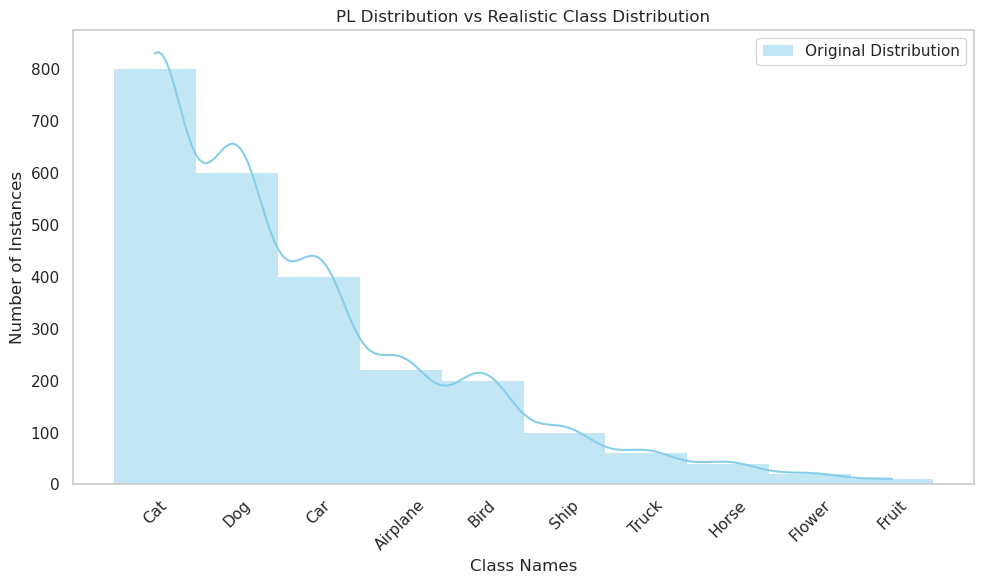

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Realistic class label count information and class names
class_names = ['Cat', 'Dog', 'Car', 'Airplane', 'Bird', 
               'Ship', 'Truck', 'Horse', 'Flower', 'Fruit']
class_counts = [800, 600, 400, 220, 200, 100, 60, 40, 20, 10]

# Additional class counts for the same classes
additional_class_counts = [600, 400, 300, 180, 150, 80, 40, 30, 15, 8]

# Combine the counts
combined_class_counts = [a + b for a, b in zip(class_counts, additional_class_counts)]

# Create a histogram with KDE
sns.set(style="whitegrid", rc={"grid.linewidth": 0})
plt.figure(figsize=(10, 6))

# Define an offset for the additional distribution
offset = 2

# Create histograms with adjusted y-values
sns.histplot(data=np.repeat(class_names, class_counts), bins=len(class_names), kde=True, color='skyblue', edgecolor='None', label='Original Distribution')

# Customize the plot
plt.title('PL Distribution vs Realistic Class Distribution')
plt.xlabel('Class Names')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.legend()  # Show legend
plt.tight_layout()

# Show the plot
plt.show()

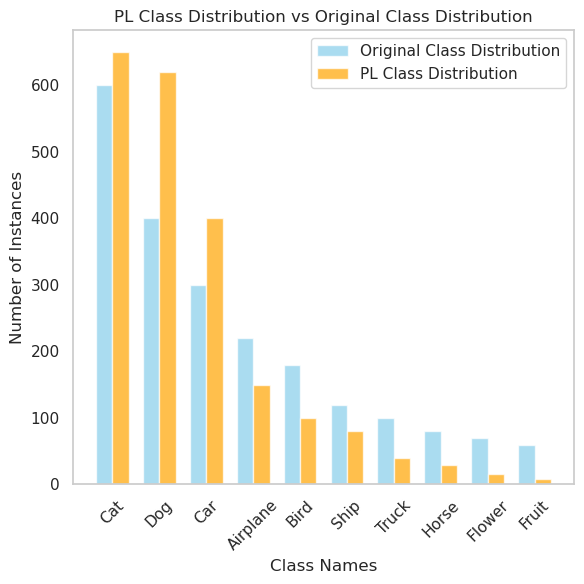

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Realistic class label count information and class names
class_names = ['Cat', 'Dog', 'Car', 'Airplane', 'Bird', 
               'Ship', 'Truck', 'Horse', 'Flower', 'Fruit']
class_counts = [600, 400, 300, 220, 180, 120, 100, 80, 70, 60]

# Additional class counts for the same classes
additional_class_counts = [650, 620, 400, 150, 100, 80, 40, 30, 15, 8]

# Combine the counts
combined_class_counts = [a + b for a, b in zip(class_counts, additional_class_counts)]

# Create a histogram with KDE
sns.set(style="whitegrid", rc={"grid.linewidth": 0})
plt.figure(figsize=(6, 6))

# Calculate the width of the bars
bar_width = 0.35

# Calculate positions for the bars of each distribution
x1 = np.arange(len(class_names))
x2 = [x + bar_width for x in x1]

# Create histograms with different color palettes and adjusted width
plt.bar(x1, class_counts, width=bar_width, color='skyblue', alpha=0.7, label='Original Class Distribution')
plt.bar(x2, additional_class_counts, width=bar_width, color='orange', alpha=0.7, label='PL Class Distribution')

# Customize the plot
plt.title('PL Class Distribution vs Original Class Distribution')
plt.xlabel('Class Names')
plt.ylabel('Number of Instances')
plt.xticks([x + bar_width / 2 for x in x1], class_names, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


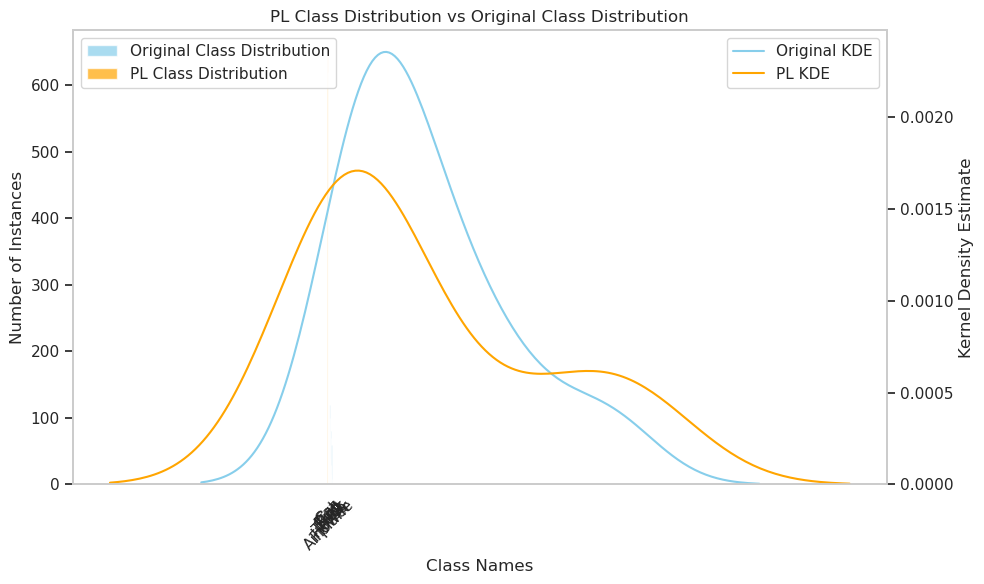

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Realistic class label count information and class names
class_names = ['Cat', 'Dog', 'Car', 'Airplane', 'Bird', 
               'Ship', 'Truck', 'Horse', 'Flower', 'Fruit']
class_counts = [600, 400, 300, 220, 180, 120, 100, 80, 70, 60]

# Additional class counts for the same classes
additional_class_counts = [650, 620, 400, 150, 100, 80, 40, 30, 15, 8]

# Combine the counts
combined_class_counts = [a + b for a, b in zip(class_counts, additional_class_counts)]

# Calculate the width of the bars
bar_width = 0.35

# Calculate positions for the bars of each distribution
x1 = np.arange(len(class_names))
x2 = [x + bar_width for x in x1]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create grouped bar plots
ax1.bar(x1, class_counts, width=bar_width, color='skyblue', alpha=0.7, label='Original Class Distribution')
ax1.bar(x2, additional_class_counts, width=bar_width, color='orange', alpha=0.7, label='PL Class Distribution')

# Set labels, title, and legend
ax1.set_xlabel('Class Names')
ax1.set_ylabel('Number of Instances')
ax1.set_title('PL Class Distribution vs Original Class Distribution')
ax1.set_xticks([x + bar_width / 2 for x in x1])
ax1.set_xticklabels(class_names, rotation=45)
ax1.legend(loc='upper left')

# Create a twin Axes sharing the xaxis for KDE plots
ax2 = ax1.twinx()

# Create KDE plots
sns.kdeplot(data=class_counts, color='skyblue', ax=ax2, label='Original KDE')
sns.kdeplot(data=additional_class_counts, color='orange', ax=ax2, label='PL KDE')

# Set labels for the KDE y-axis
ax2.set_ylabel('Kernel Density Estimate')

# Show the legend for the KDE plots
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


## Pretrain stage

### Model:
- create a seperate projector head

### Target for Projector:
- Create EMA of the ROIs whose IOU wrt GT scores >= 0.7 i.e., only the confident FGs.
- Consider their embeddings as feature level targets for the projector
- in the first 30 iterations we directly mean the classwise roi's features and make them as targets
- after 30 iterations we start to mean the per batch features classwise and do EMA with the previous batches' features

### Loss:
- Prefilter the ROIs based on IOU wrt GT scores >=0.7
- To do similarity aware cross entropy loss with the feature level targets of the previous epoch
- Minimize this loss to make the features of a class distinguishable in space from other classes
- Features outputted by the projector head is then oriented in space
- projector layer is a copy of shared features 

## DATA:
- features trained on strongly augmented labeled data


## Pretrain ++:
- GT sampling technique
- GT boxes
- obtain the features for the Weakly Augmented Labeled data


### Second stage:
- weakly augmented Labled GTs' features
- classwise thresholding 0.7,0.5,0.5
- student's predictions on the class... compare it in the prototypical space, how close is it with each other. 
- do classwise contrastive loss in space
